In [1]:
import matplotlib.pyplot as plt
from skimage.filters import frangi, hessian
import nibabel as nib
import numpy as np
import dicom2nifti as dcm2nii
import os

In [ ]:
#Skull stripping and preprocessing?

## Load T2 & ROI nifti files

In [2]:
input_directory = '../data/PVAS_Data/'
output_directory = '../data/'

In [3]:
fn_t2 = os.path.join(input_directory, 'Nifti/T2_20240405092639_6.nii')
fn_roi = os.path.join(input_directory, 'WM_Masks/ip2T2_20240405092639_6.nii')

t2 = nib.load(fn_t2)
roi = nib.load(fn_roi)

t2d = t2.get_fdata()
roid = roi.get_fdata()

print(t2d.shape, roi.shape)

(256, 320, 320) (256, 320, 320)


## Frangi filtering 

In [13]:
pvsd = frangi(t2d, sigmas=(1, 2), scale_step=1, black_ridges=False)  

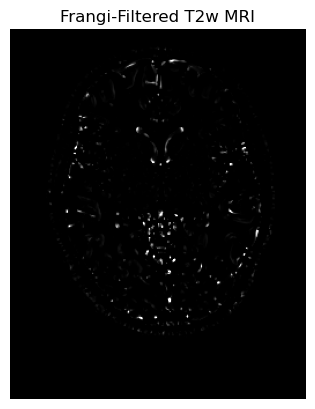

In [25]:
plt.imshow(np.rot90(pvsd[:,:,180]),cmap='gray',vmax=0.15)
plt.axis('off')
plt.title('Frangi-Filtered T2w MRI')
plt.show()

## ROI masking & thresholding


In [40]:
pvs_th = 0.0015
pvsdwm = np.copy(pvsd)
pvsdwm[roid==0]=0

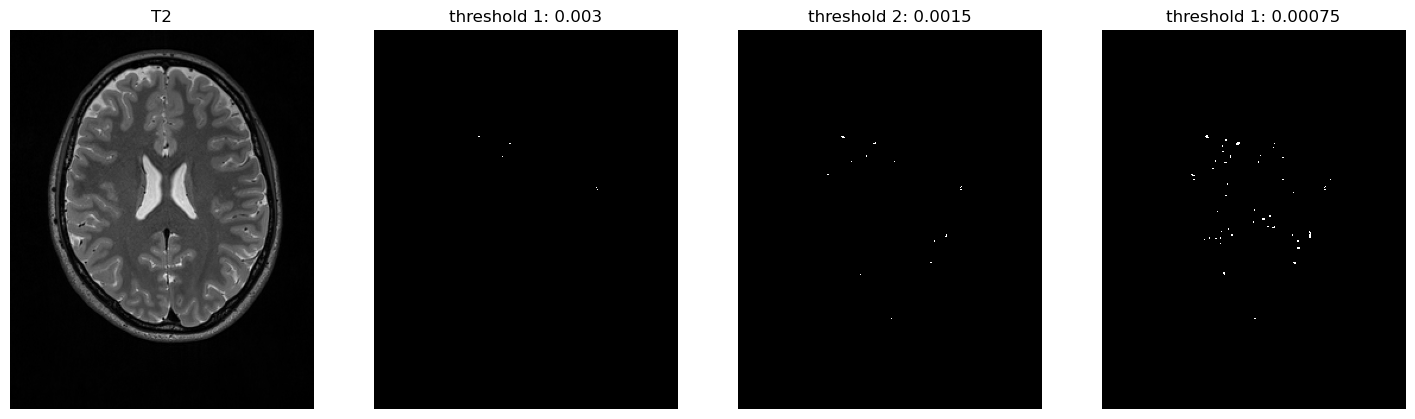

In [41]:
n=210
plt.figure(figsize=(18,18))
plt.subplot(141)
plt.imshow(np.rot90(t2d[:,:,n]),cmap='gray')
plt.title('T2')
plt.axis('off')
plt.subplot(142)
plt.imshow(np.rot90(pvsdwm[:,:,n]>pvs_th*2),cmap='gray',interpolation='nearest')
plt.title(f'threshold 1: {pvs_th*2}')
plt.axis('off')
plt.subplot(143)
plt.imshow(np.rot90(pvsdwm[:,:,n]>pvs_th),cmap='gray',interpolation='nearest')
plt.axis('off')
plt.title(f'threshold 2: {pvs_th}')
plt.subplot(144)
plt.imshow(np.rot90(pvsdwm[:,:,n]>pvs_th*(1/2)),cmap='gray',interpolation='nearest')
plt.axis('off')
plt.title(f'threshold 1: {pvs_th*0.5}')
plt.show()

### Save the filtered mask

In [42]:
pvsmsk = (pvsdwm>pvs_th).astype(np.int8)
h = nib.Nifti1Image(pvsmsk,t2.affine,t2.header)
nib.save(h,'../data/PVAS_Data/PVS_20240405092639_6_00015.nii')

## Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Data Preparation
# Load and preprocess the training data, perform data augmentation, and label the patches

# Step 2: Model Architecture
model = models.Sequential([
    # Convolutional layers
    layers.Conv3D(8, kernel_size=(3, 3, 3), activation='relu', input_shape=(24, 24, 24, num_channels)),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu'),
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu'),
    layers.MaxPooling3D((2, 2, 2)),
    # Fully connected layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # Output layer
    layers.Dense(3, activation='softmax')  # Assuming 3 classes: dPVS, false positives around ventricles, and false positives around subarachnoid space
])

# Step 3: Loss Function and Optimization
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Training
model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size)

# Step 5: Inference
# Use the trained model to predict class labels for the test dataset

# Step 6: Calculate dPVS Volume
# Calculate the volume of dPVS based on the predicted labels and the voxel volume


## Volume Calculation

## Registration Code

In [ ]:
'''
#dcm2nii.convert_directory(dicom_directory, output_directory, compression=True, reorient=True)
import SimpleITK as sitk

# Load the processed T1 and T2 images
#processed_t1 = sitk.ReadImage("../data/T1_processed.nii.gz")
processed_t1 = fixed_image_cast
#t2 = sitk.ReadImage("../data/T2_0208.nii.gz")
t2 = moving_image_cast

# Initialize the registration method (e.g., rigid registration)
registration_method = sitk.ImageRegistrationMethod()

# Set the registration method parameters (e.g., similarity metric, optimizer)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)

# Perform registration
registration_method.SetInitialTransform(sitk.TranslationTransform(processed_t1.GetDimension()))
final_transform = registration_method.Execute(processed_t1, t2)

# Apply the transformation to the T2 image
registered_t2 = sitk.Resample(t2, processed_t1, final_transform, sitk.sitkLinear, 0.0)

#sitk.WriteImage(registered_t2, '../data/registered_t2.nii.gz')

import SimpleITK as sitk

# Load the fixed and moving images
fixed_image = sitk.ReadImage("../data/T1_processed.nii.gz")
moving_image = sitk.ReadImage("../data/T2_0208.nii.gz")

# Convert the data type of the moving image to match the fixed image
fixed_image_cast = sitk.Cast(fixed_image, sitk.sitkFloat32)  # Example: Convert to float32
moving_image_cast = sitk.Cast(moving_image, sitk.sitkFloat32)

# Print the data types of the images
print("Fixed image data type:", fixed_image_cast.GetPixelIDTypeAsString())
print("Moving image data type:", moving_image_cast.GetPixelIDTypeAsString())
'''